In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import random
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import random as rand
from tqdm import tqdm
from skimage.io import imread
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [5]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
base_path = Path.cwd().parent / 'Data Sets/2023_02_07_DPI-nadphox-inhib'
#base_path = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set/')

images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

image_num = str(11)

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))


In [6]:
raw_tif = imread(images_folder / '{}.tif'.format(image_num))


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

<Axes: xlabel='timepoint', ylabel='circle_radius'>

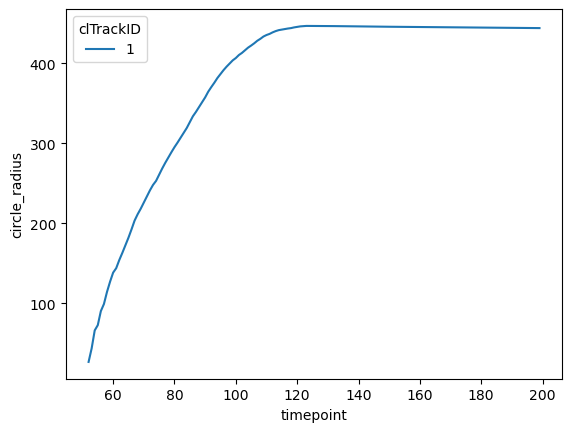

In [7]:
sns.lineplot(data=wave_df, x='timepoint', y='circle_radius', hue='clTrackID')

In [8]:
#Lets select the example wave:
ex_wave_num = 1
ex_wave_DF = wave_df[wave_df['clTrackID']==ex_wave_num]
ex_arcos_DF = arcos_df[arcos_df['clTrackID']==ex_wave_num]
start_time = ex_wave_DF.timepoint.min()
pre_wave_time = start_time - 12 #one min prior to wave
end_time = 85
post_wave_time = end_time + 2 #four min after wave

In [9]:
(5/60)*(post_wave_time - start_time)

2.9166666666666665

In [10]:
ex_wave_DF[ex_wave_DF['timepoint']==start_time]

,clTrackID,timepoint,rel_time,rel_r,r_squared,circle_radius,radius_velocity,radius_acceleration,wave_centroid,cell_density,trackable,ca_avg_sig,split,drug_name,drug_dose,volunteer_ID
0,1,52,0,0.0,0.0,26.474146,3.386878,0.111,"[172.0, 176.2]",6757.194766,True,377.182305,0.0,DPI,50uM,8


In [11]:
#Getting a circle from set: 
ex_time = end_time
vmin_set = 200
vmax_set = 1000
border_color = '#B54845'
border_width = 12
crop_buffer = 165

i_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==start_time].wave_centroid.values[0]
i_wave_center = [int(val) for val in i_wave_center]

i_wave_r = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].circle_radius.values[0]/2.2 #need to convert back from um to px
wave_center = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].wave_centroid.values[0]
i_wave_center = [int(val) for val in i_wave_center]

In [12]:

crop_im = raw_tif[ex_time, 0,:,:][i_wave_center[1]-crop_buffer:i_wave_center[1]+crop_buffer,i_wave_center[0]-crop_buffer:i_wave_center[0]+crop_buffer]

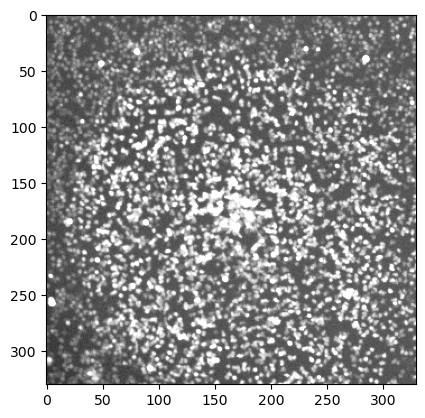

In [13]:
plt.imshow(crop_im, cmap='Greys_r', vmin=100, vmax=900)

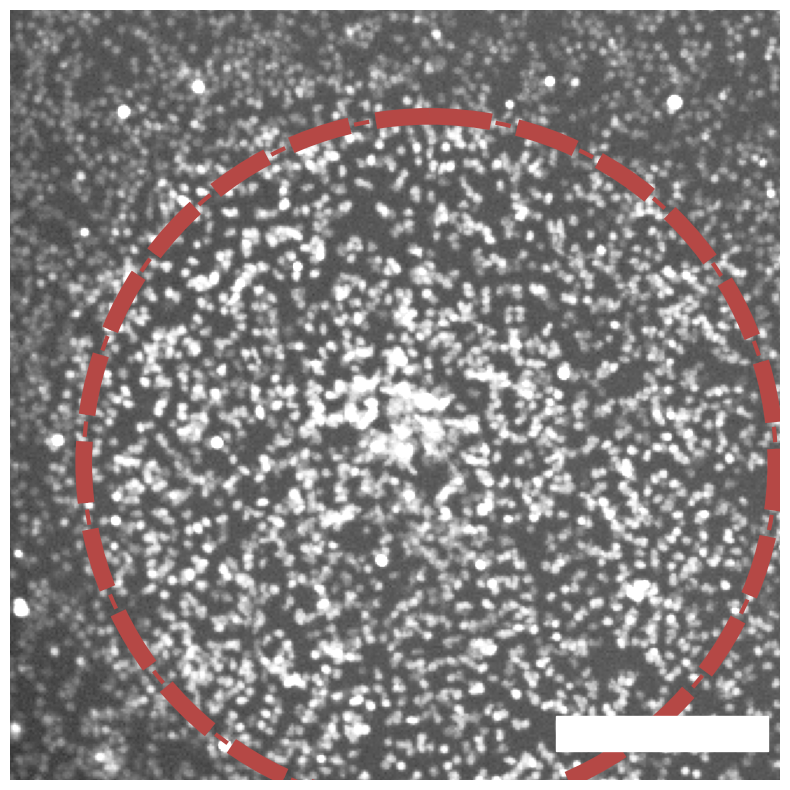

In [14]:
#Lets start by getting the first frame of the wave? 
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(raw_tif[ex_time, 0,:,:], cmap='Greys_r', vmin=50, vmax=1000)
circle1 = plt.Circle(wave_center, i_wave_r, color='#B54845', fill=False, linestyle='--', linewidth=3)
ax.add_patch(circle1)
ax.axis('off')
circle1 = plt.Circle(wave_center, i_wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width)
ax.add_patch(circle1)
plt.ylim(i_wave_center[1]-crop_buffer,i_wave_center[1]+crop_buffer)
plt.xlim(i_wave_center[0]-crop_buffer,i_wave_center[0]+crop_buffer)
plt.gca().invert_yaxis()
scalebar = AnchoredSizeBar(ax.transData,
                           200/2.2, '',  'lower right', 
                           pad=0.75,
                           color='white',
                           frameon=False,
                           size_vertical=15)

ax.add_artist(scalebar) 

In [15]:
cmap_custom = LinearSegmentedColormap.from_list(colors=['#FFFFFF','#4A8F62'], name='white-green')

In [16]:
custom_cmap = LinearSegmentedColormap.from_list(colors=['#09121D','#6E67AD','#8E9EDD','#BFCDFB'], name='black-white-blue') 

In [17]:
#custom_cmap = colors.Colormap('viridis')

In [64]:
export_location = Path.cwd().parent / 'Fig3 - Model vs Data Stop/fig3e-stills/11/'
vmin_set = 150
vmax_set = 900
border_color = '#87ABD3'
border_width = 12
crop_buffer = 170

i_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==start_time].wave_centroid.values[0]
i_wave_center = [int(val) for val in i_wave_center]

for t in ex_wave_DF.timepoint.values:
    wave_r = ex_wave_DF[ex_wave_DF['timepoint']==t].circle_radius.values[0]/2.2 #need to convert back from um to px
    wave_center = ex_wave_DF[ex_wave_DF['timepoint']==t].wave_centroid.values[0]
    crop_im = raw_tif[t, 0,:,:][i_wave_center[1]-crop_buffer:i_wave_center[1]+crop_buffer,i_wave_center[0]-crop_buffer:i_wave_center[0]+crop_buffer]
    wave_center_translate = [wave_center[0] - i_wave_center[0] + crop_buffer, wave_center[1] - i_wave_center[1] + crop_buffer]
    #Lets start by getting the first frame of the wave? 
    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(crop_im, cmap='magma', vmin=vmin_set, vmax=vmax_set)
    circle1 = plt.Circle(wave_center_translate, wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width)
    ax.add_patch(circle1)
    scalebar = AnchoredSizeBar(ax.transData,
                           200/2.2, '',  'lower right', 
                           pad=0.75,
                           color='white',
                           frameon=False,
                           size_vertical=15)

    ax.add_artist(scalebar) 
    ax.axis('off')
    plt.savefig(export_location / str(image_num + '-{}.png'.format(t)), dpi=300, bbox_inches='tight')
    plt.close()

In [54]:
base_path_ctrl_img = base_path / 'control_example_set/images/0.tif'
export_location_ctrl = Path.cwd().parent / 'Fig3 - Model vs Data Stop/fig3e-stills/ctrl/'

ex_wave_DF_ctrl = pd.read_csv(base_path / 'control_example_set/wavefit_outputs/0_wave_df.csv', converters={"wave_centroid": read_tuple_list})
ex_ctrl_wave = ex_wave_DF_ctrl[ex_wave_DF_ctrl['clTrackID'] == 7]
start_time_ctrl = ex_ctrl_wave.timepoint.min()

raw_tif_ctrl = imread(base_path_ctrl_img)


In [65]:
vmin_set = 150
vmax_set = 900
border_color = '#87ABD3'
border_width = 12
crop_buffer = 170

i_wave_center = ex_ctrl_wave[ex_ctrl_wave['timepoint']==start_time_ctrl].wave_centroid.values[0]
i_wave_center = [int(val) for val in i_wave_center]

for t in ex_ctrl_wave.timepoint.values:
    wave_r = ex_ctrl_wave[ex_ctrl_wave['timepoint']==t].circle_radius.values[0]/2.2 #need to convert back from um to px
    wave_center = ex_ctrl_wave[ex_ctrl_wave['timepoint']==t].wave_centroid.values[0]
    crop_im = raw_tif_ctrl[t, 0,:,:][i_wave_center[1]-crop_buffer:i_wave_center[1]+crop_buffer,i_wave_center[0]-crop_buffer:i_wave_center[0]+crop_buffer]
    wave_center_translate = [wave_center[0] - i_wave_center[0] + crop_buffer, wave_center[1] - i_wave_center[1] + crop_buffer]
    #Lets start by getting the first frame of the wave? 
    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(crop_im, cmap='magma', vmin=vmin_set, vmax=vmax_set)
    circle1 = plt.Circle(wave_center_translate, wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width)
    ax.add_patch(circle1)
    scalebar = AnchoredSizeBar(ax.transData,
                           200/2.2, '',  'lower right', 
                           pad=0.75,
                           color='white',
                           frameon=False,
                           size_vertical=15)

    ax.add_artist(scalebar) 
    ax.axis('off')
    plt.savefig(export_location_ctrl / str('ctrl_1' + '-{}.png'.format(t)), dpi=300, bbox_inches='tight')
    plt.close()

113

In [72]:
t = ex_ctrl_wave.timepoint.values[-1]+12

crop_im = raw_tif_ctrl[t, 0,:,:][i_wave_center[1]-crop_buffer:i_wave_center[1]+crop_buffer,i_wave_center[0]-crop_buffer:i_wave_center[0]+crop_buffer]
wave_center_translate = [wave_center[0] - i_wave_center[0] + crop_buffer, wave_center[1] - i_wave_center[1] + crop_buffer]
#Lets start by getting the first frame of the wave? 
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(crop_im, cmap='magma', vmin=vmin_set, vmax=vmax_set)
#circle1 = plt.Circle(wave_center_translate, wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width)
#ax.add_patch(circle1)
scalebar = AnchoredSizeBar(ax.transData,
                       200/2.2, '',  'lower right', 
                       pad=0.75,
                       color='white',
                       frameon=False,
                       size_vertical=15)

ax.add_artist(scalebar) 
ax.axis('off')
plt.savefig(export_location_ctrl / str('ctrl_1' + '-{}.png'.format(t)), dpi=300, bbox_inches='tight')
plt.close()

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
pre_wave_time = min(ex_wave_DF.timepoint.values) - 12
crop_im = raw_tif[pre_wave_time, 0,:,:][i_wave_center[1]-crop_buffer:i_wave_center[1]+crop_buffer,i_wave_center[0]-crop_buffer:i_wave_center[0]+crop_buffer]
plt.imshow(crop_im, cmap=cmap_custom, vmin=vmin_set, vmax=vmax_set)
ax.axis('off')
plt.savefig(export_location + image_num + '-{}.png'.format(pre_wave_time), dpi=300, bbox_inches='tight')
plt.close()